---

# Первичный анализ глобальной базы по поверке метеостанций за релевантный период

Уточняющий отчет для релевантного периода. Под релевантным периодом понимается период с 2020 года (момент выхода Сокол-М1 на рынок как сертифицированное средство измерения).

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set(style="whitegrid")

Функции для визуализации:

In [2]:
def create_pie_chart(data, labels, title):
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def create_bar_chart(data, title, xlabel, ylabel, stacked=False):
    data.plot(kind='bar', stacked=stacked)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def create_heatmap(data, title, xlabel, ylabel, annot=True, fmt='.1f', cmap='YlGnBu'):
    sns.heatmap(data, annot=annot, fmt=fmt, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def create_histogram(data, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    handles = []  # Список для хранения элементов легенды

    for label, group_data in data:
        if label == 'СОКОЛ-М1':
            alpha = 0.9
        else:
            alpha = 0.7
        if label == "Минимакс-94":
            scale_factor = 0.25 # Далее по тексту есть причина такого масштабирования
            heights, bins, _ = plt.hist(group_data['verification_date'], bins=40, visible=False)
            heights = [h * scale_factor for h in heights]
            bar_color = 'purple'
            bar = plt.bar(bins[:-1], heights, width=(bins[1] - bins[0]), alpha=alpha, color=bar_color)
            handles.append(Line2D([0], [0], color=bar_color, lw=2, label=label))
        else:
            hist = plt.hist(group_data['verification_date'], bins=40, alpha=alpha, label=label)
            handles.append(Line2D([0], [0], color=hist[2][0].get_facecolor(), lw=2, label=label))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles)  # Добавляем список элементов легенды
    plt.show()

Загрузим данные:

In [3]:
df = pd.read_excel('data/all_data_with_new_columns.xlsx')

Выведем первые пять строк и основную информацию о датафрейме:

In [4]:
df.head()

,mi.mitnumber,mi.modification,mi.number,valid_date,result_docnum,result_text,mi.mitype,mi.mititle,org_title,vri_id,verification_date,check,station_age,verification_year,mi.manufacturer
0,77386-20,ДВС-01,6190231,2024-06-25,С-ТТ/26-06-2023/257692661,Пригодно,ДВС-01,Датчики скорости ветра,"ФБУ ""РОСТЕСТ-МОСКВА""",1-257692661,2023-06-26,Первичная,0.0,2023,Минимакс-94
1,77386-20,ДВС-01,6200074,2024-06-25,С-ТТ/26-06-2023/257692660,Пригодно,ДВС-01,Датчики скорости ветра,"ФБУ ""РОСТЕСТ-МОСКВА""",1-257692660,2023-06-26,Первичная,0.0,2023,Минимакс-94
2,77386-20,Нет модификации,46200071,2024-03-22,С-В/23-03-2023/234738786,Пригодно,ДВС-01,Датчики скорости ветра,"ФГУП ""ВНИИМ ИМ. Д.И.МЕНДЕЛЕЕВА""",1-234738786,2023-03-23,Первичная,0.0,2023,Минимакс-94
3,77386-20,Нет модификации,46200114,2024-03-22,С-В/23-03-2023/234738796,Пригодно,ДВС-01,Датчики скорости ветра,"ФГУП ""ВНИИМ ИМ. Д.И.МЕНДЕЛЕЕВА""",1-234738796,2023-03-23,Первичная,0.0,2023,Минимакс-94
4,77386-20,Нет модификации,46200129,2024-03-22,С-В/23-03-2023/234738792,Пригодно,ДВС-01,Датчики скорости ветра,"ФГУП ""ВНИИМ ИМ. Д.И.МЕНДЕЛЕЕВА""",1-234738792,2023-03-23,Первичная,0.0,2023,Минимакс-94


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   mi.mitnumber       11200 non-null  object        
 1   mi.modification    10825 non-null  object        
 2   mi.number          11200 non-null  object        
 3   valid_date         10531 non-null  datetime64[ns]
 4   result_docnum      11200 non-null  object        
 5   result_text        11200 non-null  object        
 6   mi.mitype          11200 non-null  object        
 7   mi.mititle         11200 non-null  object        
 8   org_title          11200 non-null  object        
 9   vri_id             11200 non-null  object        
 10  verification_date  11200 non-null  datetime64[ns]
 11  check              11200 non-null  object        
 12  station_age        10977 non-null  float64       
 13  verification_year  11200 non-null  int64         
 14  mi.man

Вычислим диапазон дат поверки метеостанций (СИ) в базе данных:

In [6]:
min(df['verification_date']), max(df['verification_date'])

(Timestamp('2018-02-05 12:00:00'), Timestamp('2023-12-07 00:00:00'))

Релевантными данными является период с 2020 года, отфильтруем датасет:

In [7]:
df = df.query('verification_year >= 2020')

In [8]:
min(df['verification_date']), max(df['verification_date'])

(Timestamp('2020-01-10 12:00:00'), Timestamp('2023-12-07 00:00:00'))

Посмотрим, сколько всего метеостанций (СИ) проходили поверку:

In [9]:
df['mi.number'].value_counts()

mi.number
12                   32
19                   29
16                   28
17                   28
8                    27
                     ..
052.1017.0811.224     1
052151                1
052154                1
052171                1
в.н 418381/1          1
Name: count, Length: 5304, dtype: int64

Всего 5023 метеостанций (СИ).

Построим круговую диаграмму с долей производителей метеостанций (СИ), проходящих поверку:

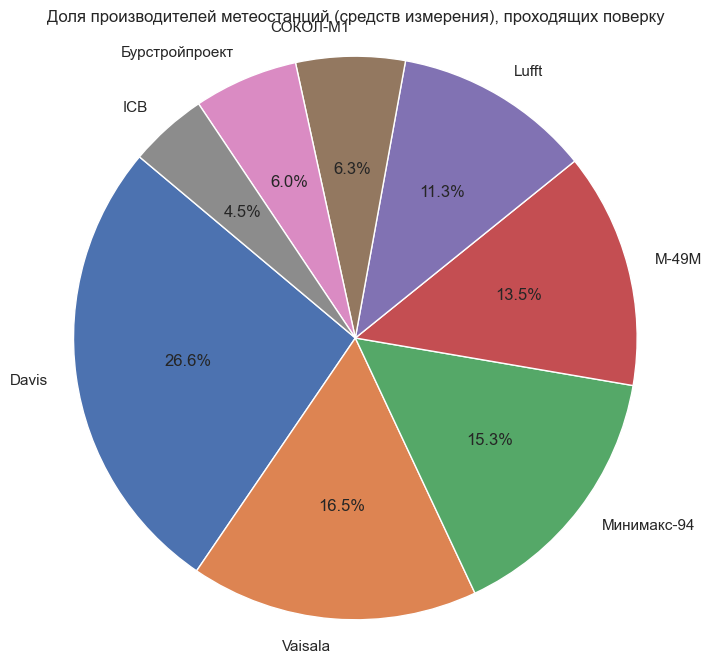

In [10]:
mi_type_counts = df['mi.manufacturer'].value_counts()
create_pie_chart(mi_type_counts, mi_type_counts.index, 'Доля производителей метеостанций (средств измерения), проходящих поверку')

Важно отметить, что производитель "Минимакс-94" производит именно СИ - датчики, а не метеостанции. Посмотрим круговую диаграмму типов СИ, производимых этим производителем:

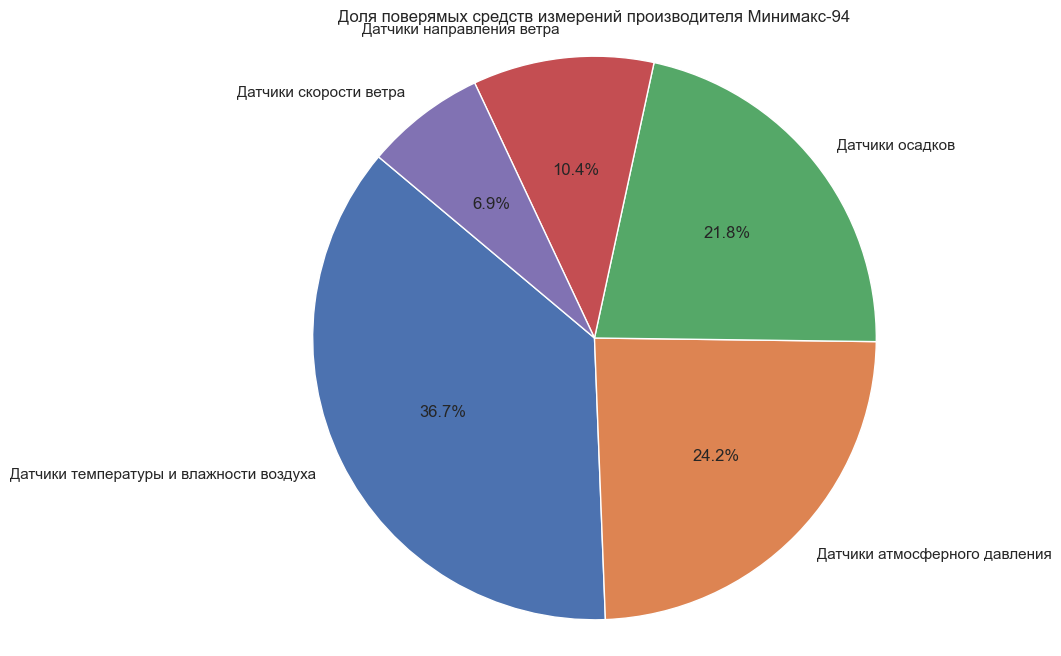

In [11]:
mi_type_counts = df[df['mi.manufacturer'] == 'Минимакс-94']['mi.mititle'].value_counts()
create_pie_chart(mi_type_counts, mi_type_counts.index, 'Доля поверямых средств измерений производителя Минимакс-94')

Метеостанции включают в себя различные типы датчиков, предназначенных для измерения различных параметров окружающей среды. В данном случае мы имеем пять типов датчиков: датчики температуры и влажности воздуха, датчики атмосферного давления, датчики осадков, датчики направления ветра и датчики скорости ветра. Очевидно, что количество датчиков каждого типа в метеостанции может существенно различаться.


Другим аспектом, который следует учесть, является важность измеряемых параметров. Например, для прогноза погоды чрезвычайно важны параметры, такие как температура, влажность воздуха и атмосферное давление. Они оказывают существенное воздействие на климатические условия. В то время как направление и скорость ветра, а также осадки, хотя и важны, могут иметь менее сильное воздействие на общий прогноз.


Исходя из вышеизложенного, для учета неравномерной доли различных типов датчиков в метеостанции, разумно делить общее количество датчиков не на 5, а на 4 (в анализе первичных и периодических поверок). Это позволит учесть важность параметров и неравномерное распределение датчиков.

Представим в виде барового графика число поверок каждого производителя с разбивкой по типу поверки:

C:\Users\User\AppData\Local\Temp\ipykernel_4632\1198018384.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '355.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mi_type_check_counts.loc['Минимакс-94'] = mi_type_check_counts.loc['Минимакс-94'] / 4 # Учитываем вышесказанное


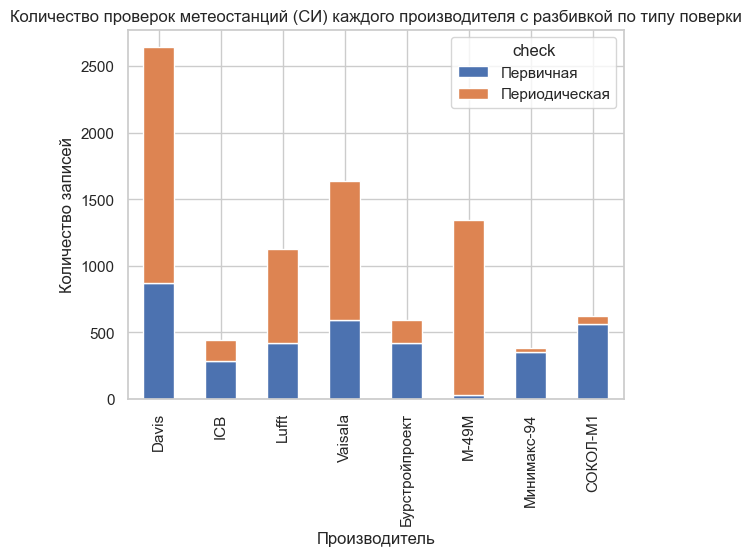

In [12]:
mi_type_check_counts = df.groupby(['mi.manufacturer', 'check']).size().unstack()

mi_type_check_counts.loc['Минимакс-94'] = mi_type_check_counts.loc['Минимакс-94'] / 4 # Учитываем вышесказанное

create_bar_chart(
    mi_type_check_counts, 
    'Количество проверок метеостанций (СИ) каждого производителя с разбивкой по типу поверки', 
    'Производитель', 
    'Количество записей', 
    stacked=True)

Представим в виде барового графика средний возраст метеостанций (СИ) каждого производителя:

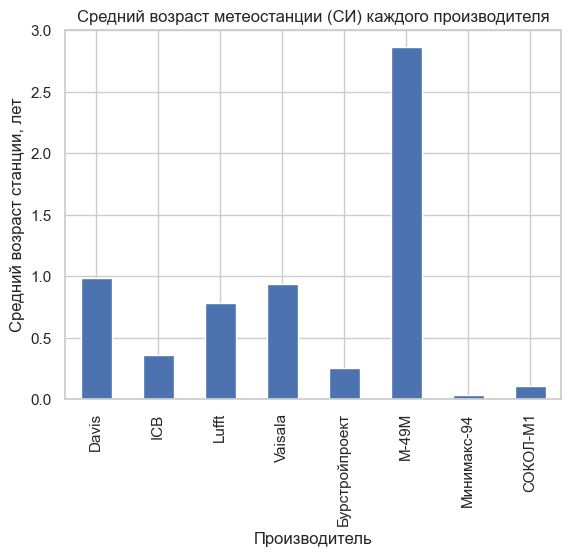

In [13]:
mi_type_avg_station_age = df.groupby('mi.manufacturer')['station_age'].mean()
create_bar_chart(
    mi_type_avg_station_age, 
    'Средний возраст метеостанции (СИ) каждого производителя', 
    'Производитель', 
    'Средний возраст станции, лет'
    )

Представим распределение возраста метеостанций (СИ) для каждого производителя в качестве гистограмм:

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


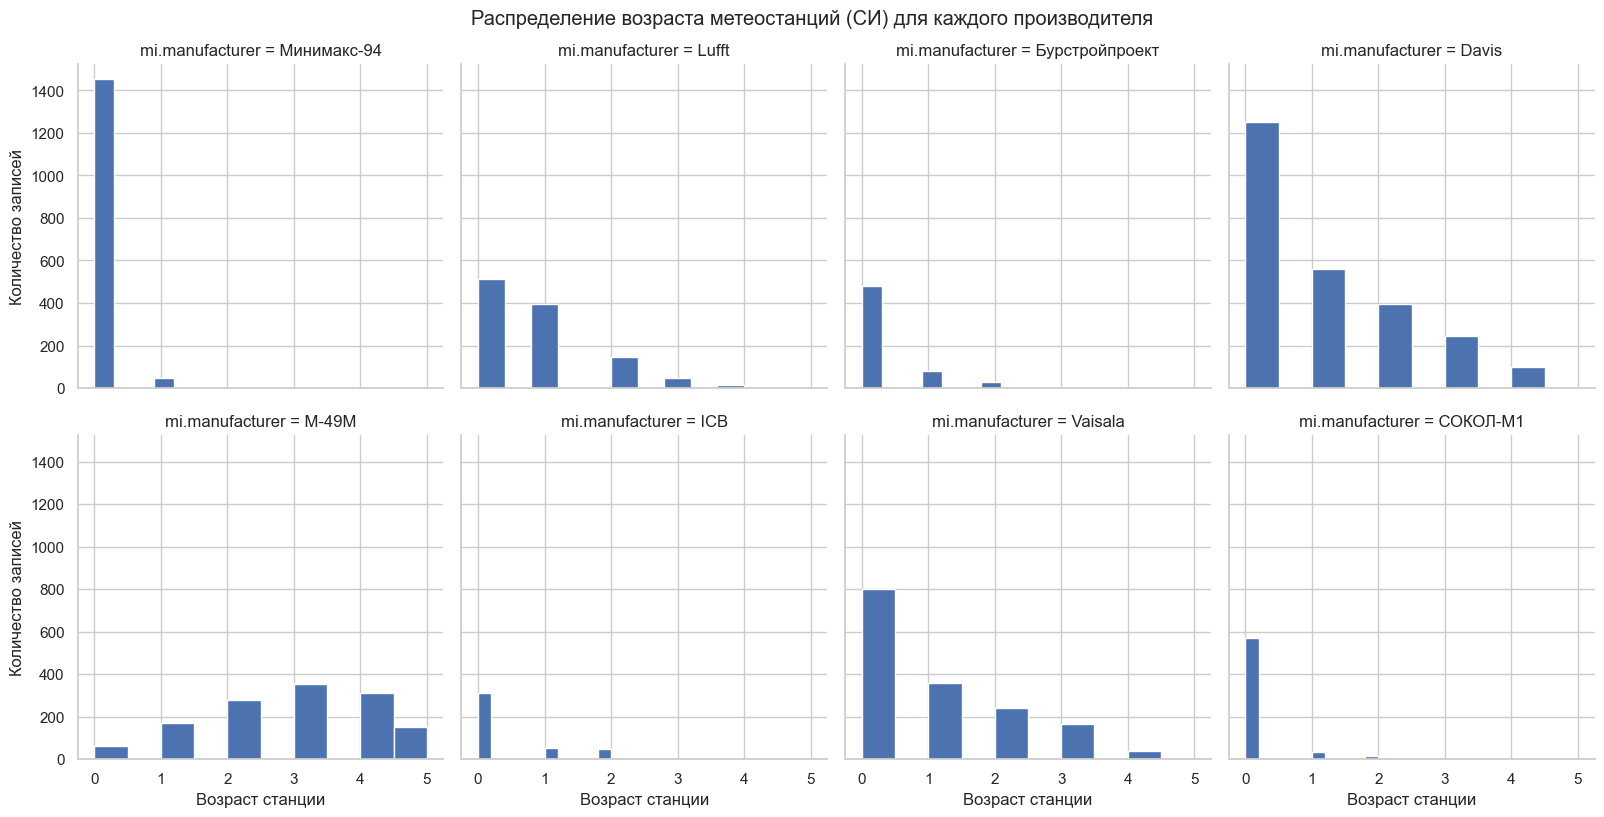

In [14]:
g = sns.FacetGrid(df, col="mi.manufacturer", height=4, col_wrap=4)
g.map(plt.hist, 'station_age', bins=10)
g.set_axis_labels('Возраст станции', 'Количество записей')
plt.suptitle('Распределение возраста метеостанций (СИ) для каждого производителя', y=1.02)
plt.show()

Представим в виде тепловой карты количество поверок метеостанций (СИ) каждого производителя с разбивкой по типу и результату поверки:

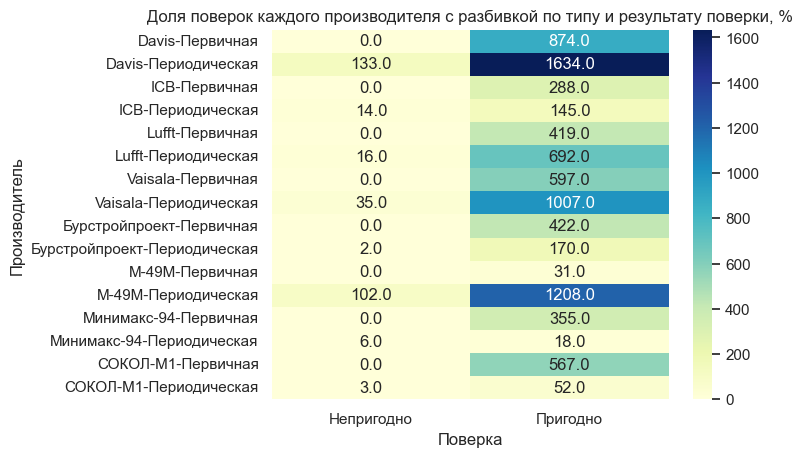

In [15]:
mi_type_check_result_counts = df.groupby(['mi.manufacturer', 'check', 'result_text']).size().unstack().fillna(0)

# Учитываем множитель 1/4 для категории "Минимакс-94"
checks = ['Периодическая', 'Первичная']
for check in checks:
    mi_type_check_result_counts.loc[('Минимакс-94', check), 
                                    'Непригодно'] = mi_type_check_result_counts.loc[('Минимакс-94', check), 'Непригодно'] // 4
    mi_type_check_result_counts.loc[('Минимакс-94', check), 
                                    'Пригодно'] = mi_type_check_result_counts.loc[('Минимакс-94', check), 'Пригодно'] // 4

create_heatmap(
    mi_type_check_result_counts, 
    'Доля поверок каждого производителя с разбивкой по типу и результату поверки, %', 
    'Поверка', 
    'Производитель')

И долю таких поверок:

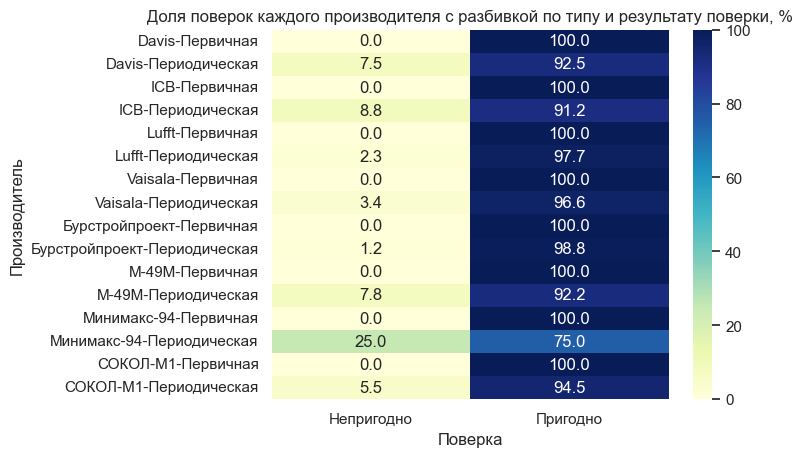

In [16]:
mi_type_check_result_percentages = mi_type_check_result_counts.div(mi_type_check_result_counts.sum(axis=1), axis=0) * 100
create_heatmap(
    mi_type_check_result_percentages, 
    'Доля поверок каждого производителя с разбивкой по типу и результату поверки, %', 
    'Поверка', 
    'Производитель')

Представим в виде гистограммы число поверок по датам для каждого производителя:

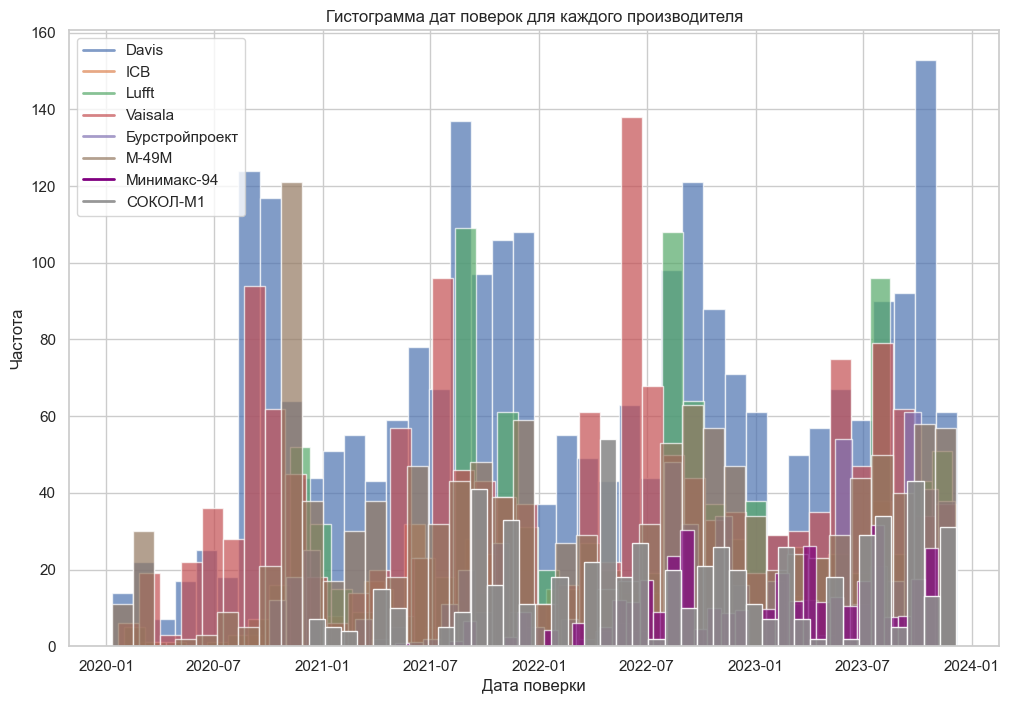

In [17]:
manufacturer_groups = df.groupby('mi.manufacturer')
create_histogram(
    manufacturer_groups, 
    'Гистограмма дат поверок для каждого производителя', 
    'Дата поверки', 
    'Частота'
)

Также большой интерес представляют данные о первичной поверке метеостанций (СИ), эта информация говорит о том, сколько производитель продавал метеостанций (СИ) ежегодно:

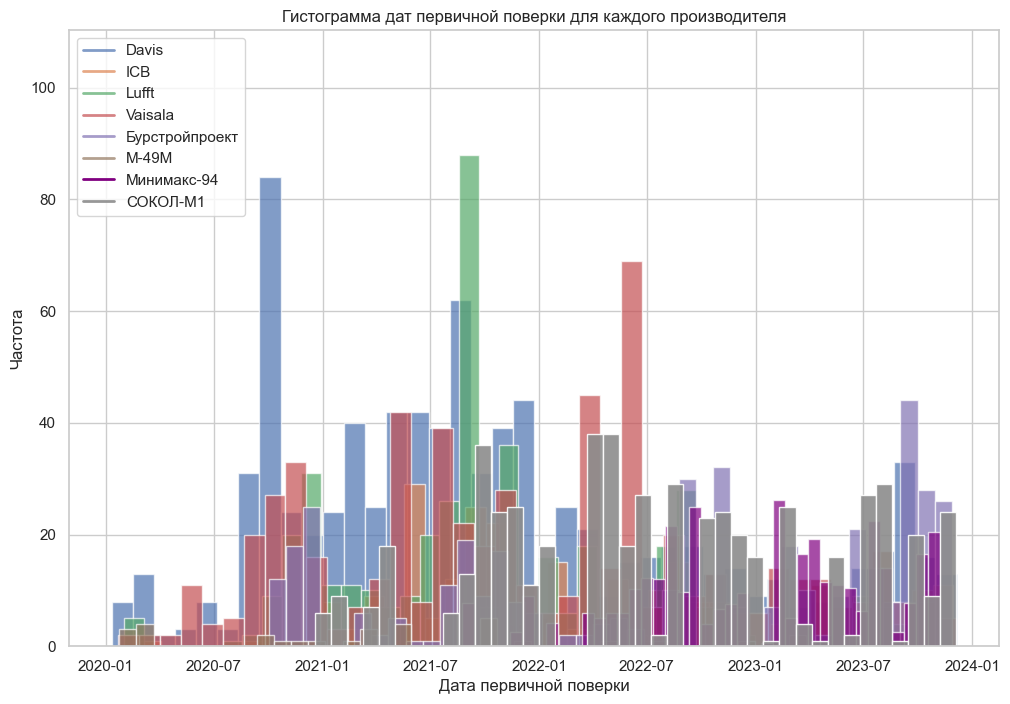

In [18]:
manufacturer_groups_primary = df[df['check'] == 'Первичная'].groupby('mi.manufacturer')
create_histogram(
    manufacturer_groups_primary,
      'Гистограмма дат первичной поверки для каждого производителя', 
      'Дата первичной поверки', 
      'Частота'
)

Построим сводную таблицу по числу поверок:

In [19]:
pivot_table = df.pivot_table(
    index=['check', 'mi.manufacturer'], 
    columns='verification_year', 
    values='mi.mitnumber', 
    aggfunc='count', 
    fill_value=0
)

# Учитываем множитель 1/4 для категории "Минимакс-94"
checks = ['Периодическая', 'Первичная']
for check in checks:
    pivot_table.loc[(check, 'Минимакс-94')] = pivot_table.loc[(check, 'Минимакс-94')] // 4

pivot_table

verification_year              2020  2021  2022  2023
check         mi.manufacturer                        
Первичная     Davis             196   388   162   128
              ICB                 3   120    82    83
              Lufft              68   228   100    23
              Vaisala           122   194   198    83
              Бурстройпроект     55    85    95   187
              М-49М              12    14     3     2
              Минимакс-94         0    19   145   190
              СОКОЛ-М1            6   149   248   164
Периодическая Davis             256   430   526   555
              ICB                 7    20    48    84
              Lufft              39    86   282   301
              Vaisala           211   192   285   354
              Бурстройпроект      0    13    60    99
              М-49М             228   360   374   348
              Минимакс-94         0     0     5    18
              СОКОЛ-М1            1     0     1    53

---